In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from utils import (
    process_features,
    get_significant_variables,
    plot_feature_weights_horizontal_sm,
)
import statsmodels.api as sm

In [24]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "beneficiary_avg_age",
    "pct_beneficiaries_female",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "pct_beneficiaries_white",
    "pct_beneficiaries_black",
    "pct_beneficiaries_hispanic",
    "pct_beneficiaries_medicare_medicaid",
    # "pct_beneficiaries_afib",
    # "pct_beneficiaries_osteoporosis",
    # "pct_beneficiaries_chronic_kidney_disease",
    # "pct_beneficiaries_cancer",
]
df = pd.read_csv(
    (DATA_PATH / "obt_slimmer.csv"),
    usecols=cols_of_interest,
)

### drop nans
df.dropna(inplace=True)

### remove 'beneficiaries_' from col names
df.columns = df.columns.str.replace("beneficiaries_", "")

### Calculate new columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df["pct_non_white"] = 1 - df["pct_white"]


### Condition Query
condition = "hf"  ###### ENTER NAME HERE #####
if condition == "hf":
    df = df.query("condition_name == 'Heart Failure'")
elif condition == "copd":
    df = df.query("condition_name == 'Chronic Obstructive Pulmonary Disease'")
elif condition == "pn":
    df = df.query("condition_name == 'Pneumonia'")

### Drop extra columns
df.drop(
    columns=[
        "number_of_readmissions",
        "number_of_discharges",
        "pct_white",
        "condition_name",
    ],
    inplace=True,
)

### Transform Data
log_transform = [
    # "pct_psychotic_disorders",
    # "pct_black",
    # "pct_hispanic",
    # "pct_non_white",
    # "pct_medicare_medicaid",
]

# for col in df.columns:
#     if col in log_transform:
#         df[col] = np.log10(df[col])

### SAVE OUT DMS
DM_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/code/jess/design_matrices")

# y
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)
y.to_csv(DM_PATH / f"{condition}_y.csv", index=False)

# X
X = df.drop(columns=["readmission_rate"])
X.reset_index(drop=True, inplace=True)

X_race_1 = X.drop(columns=["pct_black", "pct_hispanic"])
X_race_2 = X.drop(columns=["pct_non_white"])
X_base = X.drop(columns=["pct_non_white", "pct_black", "pct_hispanic"])

X_race_1.to_csv(DM_PATH / f"{condition}_X_race1.csv", index=False)
X_race_2.to_csv(DM_PATH / f"{condition}_X_race2.csv", index=False)
X_base.to_csv(DM_PATH / f"{condition}_X_base.csv", index=False)

In [25]:
### READ IN
y = pd.read_csv(DM_PATH / f"{condition}_y.csv", index_col=False)
y = y.squeeze()

X_race_1 = pd.read_csv(DM_PATH / f"{condition}_X_race1.csv")
X_race_2 = pd.read_csv(DM_PATH / f"{condition}_X_race2.csv")
X_base_2 = pd.read_csv(DM_PATH / f"{condition}_X_base.csv")

In [27]:
# Linear Model
usdf = X_race_2
X_standardized = process_features(
    usdf,
    numeric_cols=usdf.columns,
)
X_standardized.reset_index(drop=True, inplace=True)
X_standardized_w_bias = sm.add_constant(X_standardized)
# X_standardized_w_bias = sm.add_constant(X_standardized)
# X_hf_race_1 = X_standardized_w_bias.drop(columns=["pct_non_white"])

linear_model = sm.OLS(y, X_standardized_w_bias)
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     57.11
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          8.05e-134
Time:                        17:21:19   Log-Likelihood:                -5060.3
No. Observations:                1919   AIC:                         1.015e+04
Df Residuals:                    1904   BIC:                         1.023e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           21.5303      0.077    277.919      0.000      21.378      21.682
beneficiary_avg_age             -0.9447      0.154     -6.129      0.000      -1.247      -0.642
pct_female                       0.3345      0.113      2.949      0.003       0.112       0.557
pct_black                        0.2907      0.140      2.083      0.037       0.017       0.564
pct_hispanic                     0.1170      0.126      0.927      0.354      -0.130       0.364
pct_medicare_medicaid            0.4420      0.155      2.860      0.004       0.139       0.745
pct_alzheimers                   0.7484      0.182      4.113      0.000       0.391       1.105
pct_congestive_heart_failure    -0.3771      0.137     -2.758      0.006      -0.645      -0.109
pct_copd                         0.6106      0.120      5.090      0.000       0.375       0.846
pct_depression                  -0.4623      0.133     -3.465      0.001      -0.724      -0.201
pct_diabetes                    -0.0067      0.183     -0.037      0.971      -0.365       0.352
pct_ischemic_heart_disease       0.6579      0.128      5.120      0.000       0.406       0.910
pct_arthritis                    0.2002      0.103      1.947      0.052      -0.001       0.402
pct_psychotic_disorders          0.3065      0.160      1.918      0.055      -0.007       0.620
pct_stroke                       0.3789      0.103      3.691      0.000       0.178       0.580
==============================================================================
Omnibus:                       66.367   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.210
Skew:                           0.251   Prob(JB):                     6.47e-28
Kurtosis:                       4.146   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

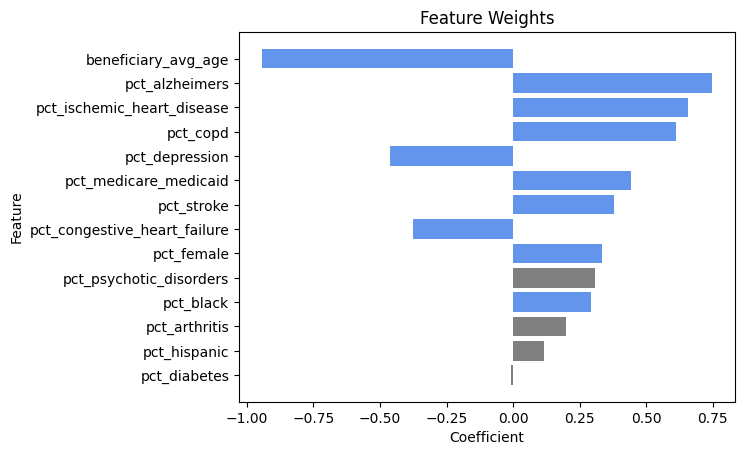

In [28]:
plot_feature_weights_horizontal_sm(linear_model)

Text(0.5, 1.0, 'Feature Weights without Log Transformed Variables')

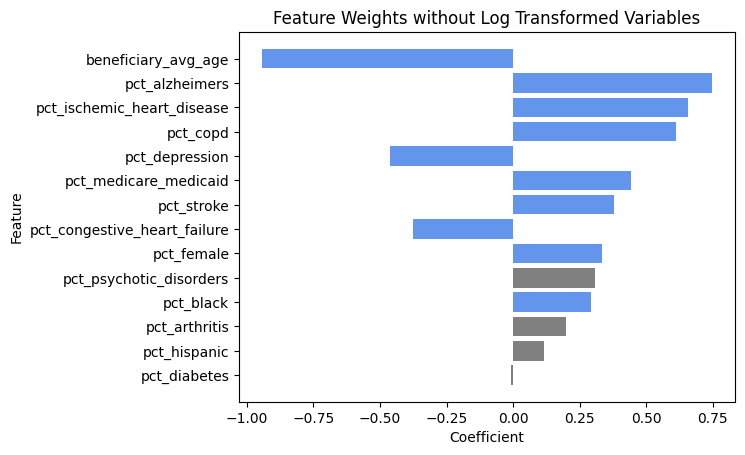

In [29]:
feature_names = linear_model.params.index[1:]  # Exclude the bias term
coefficients = linear_model.params[1:]

re_transformed_coefficeints = []
for fn in feature_names:
    if fn in log_transform:
        re_transformed_coefficeints.append(np.power(10, coefficients[fn]))
    else:
        re_transformed_coefficeints.append(coefficients[fn])
re_transformed_coefficeints = np.array(re_transformed_coefficeints)

# # Sort feature names and coefficients based on absolute coefficient values
sorted_indices = np.argsort(np.abs(re_transformed_coefficeints))
feature_names_sorted = feature_names[sorted_indices]
coefficients_sorted = re_transformed_coefficeints[sorted_indices]

significant_variables = get_significant_variables(linear_model)
# Set the color for significant and non-significant variables
colors = [
    "cornflowerblue" if var in significant_variables else "gray"
    for var in feature_names
]
colors = [colors[i] for i in sorted_indices]

# Plot the feature weights
fig, ax = plt.subplots()
ax.barh(feature_names_sorted, coefficients_sorted, color=colors)

# Set labels and title
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Feature Weights without Log Transformed Variables")

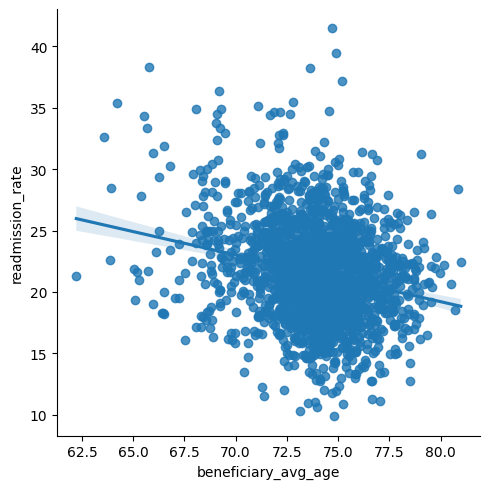

In [16]:
sns.lmplot(data=df, x="beneficiary_avg_age", y="readmission_rate")